# imports of functions

In [4]:
import argparse
import os
import sys
import pickle
import subprocess
import icelakes
from icelakes.utilities import encedc, decedc, get_size
from icelakes.nsidc import download_granule, edc
from icelakes.detection import read_atl03, detect_lakes, melt_lake

In [14]:
parser = argparse.ArgumentParser(description='Test script to print some stats for a given ICESat-2 ATL03 granule.')
parser.add_argument('--granule', type=str, default='ATL03_20220714010847_03381603_006_02.h5',
                    help='The producer_id of the input ATL03 granule')
parser.add_argument('--polygon', type=str, default='geojsons/jakobshavn_small.geojson',
                    help='The file path of a geojson file for spatial subsetting')
parser.add_argument('--is2_data_dir', type=str, default='IS2data',
                    help='The directory into which to download ICESat-2 granules')
parser.add_argument('--download_gtxs', type=str, default='all',
                    help='String value or list of gtx names to download, also accepts "all"')
parser.add_argument('--out_data_dir', type=str, default='detection_out_data',
                    help='The directory to which to write the output data')
parser.add_argument('--out_plot_dir', type=str, default='detection_out_plot',
                    help='The directory to which to write the output plots')
parser.add_argument('--out_stat_dir', type=str, default='detection_out_stat',
                    help='The directory to which to write the granule stats')
# args = parser.parse_args()
args = parser.parse_args("")

In [15]:
# try to figure out where the script is being executed (just to show those maps at conferences, etc...)
try:
    with open('location-wrapper.sh', 'rb') as file: script = file.read()
    geoip_out = subprocess.run(script, shell=True, capture_output=True)
    compute_latlon = str(geoip_out.stdout)[str(geoip_out.stdout).find('<x><y><z>')+9 : str(geoip_out.stdout).find('<z><y><x>')]
    print('\nThis job is running at the following lat/lon location:%s\n' % compute_latlon)
except:
    compute_latlon='0.0,0.0'
    print('\nUnable to determine compute location for this script.\n')

# shuffling files around for HTCondor
for thispath in (args.is2_data_dir, args.out_data_dir, args.out_plot_dir):
    if not os.path.exists(thispath): os.makedirs(thispath)

# download the specified ICESat-2 data from NSIDC
input_filename, request_status_code = download_granule(args.granule, args.download_gtxs, args.polygon, args.is2_data_dir, 
                                             decedc(edc().u), decedc(edc().p))

# perform a bunch of checks to make sure everything went alright with the nsidc api
print('Request status code:', request_status_code, request_status_code==200)
if request_status_code != 200:
    print('NSIDC API request failed.')
    sys.exit(127)
if request_status_code==200:
    with open('success.txt', 'w') as f: print('we got some sweet data', file=f)
    if input_filename == 'none': 
        print('granule seems to be empty. nothing more to do here.') 
        sys.exit(69)
if os.path.exists(input_filename):
    if os.path.getsize(input_filename) < 31457280:# 30 MB
        print('granule seems to be empty. nothing more to do here.') 
        sys.exit(69)

gtx_list, ancillary = read_atl03(input_filename, gtxs_to_read='none')


This job is running at the following lat/lon location:32.8807000,-117.2359000


  ATL03_20220714010847_03381603_006_02.h5, 1424.04 MB
  ATL03_20220714010847_03381603_006_02.h5, 1424.04 MB

Input geojson: geojsons/jakobshavn_small.geojson
Simplified polygon coordinates based on geojson input: -49.59098555896507,69.10415896488335,-50.33805587146507,68.42374368072217,-50.01945235584007,68.20452489563448,-48.47038009021507,68.14325568125464,-48.16276290271507,68.66085965388693,-48.12980391834007,69.0963205694427,-49.59098555896507,69.10415896488335

API request URL:
https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL03&producer_granule_id=ATL03_20220714010847_03381603_006_02.h5&version=006&polygon=-49.59098555896507,69.10415896488335,-50.33805587146507,68.42374368072217,-50.01945235584007,68.20452489563448,-48.47038009021507,68.14325568125464,-48.16276290271507,68.66085965388693,-48.12980391834007,69.0963205694427,-49.59098555896507,69.10415896488335&Boundingshape={"type":"FeatureCo

  reading in IS2data/processed_ATL03_20220714010847_03381603_006_02.h5
  reading in beam: gt2r  --> done.

-----------------------------------------------------------------------------

PROCESSING GROUND TRACK: gt2r (strong)
---> finding flat surfaces in photon data (57 / 734 were flat)
---> calculating photon densities & looking for second density peaks below the surface
(13 / 734 pass lake quality test)
---> merging major frame segments that possibly represent lakes iteratively
   --> iteration   0, number of lakes:   13
   --> iteration   1, number of lakes:    9
   --> iteration   2, number of lakes:    7
   --> iteration   3, number of lakes:    6
---> checking lake edges and extending them if the surface elevation matches
extending lake  0:<<<>>> 1:< 2:>>>>> 3:> 4:<> 5: 
---> calculating remaining photon densities
---> calculating photon densities & looking for second density peaks below the surface
(14 / 734 pass lake quality test)
RESULTS FOR : GT2R
  lake    0 ( 68.18922°N, 49

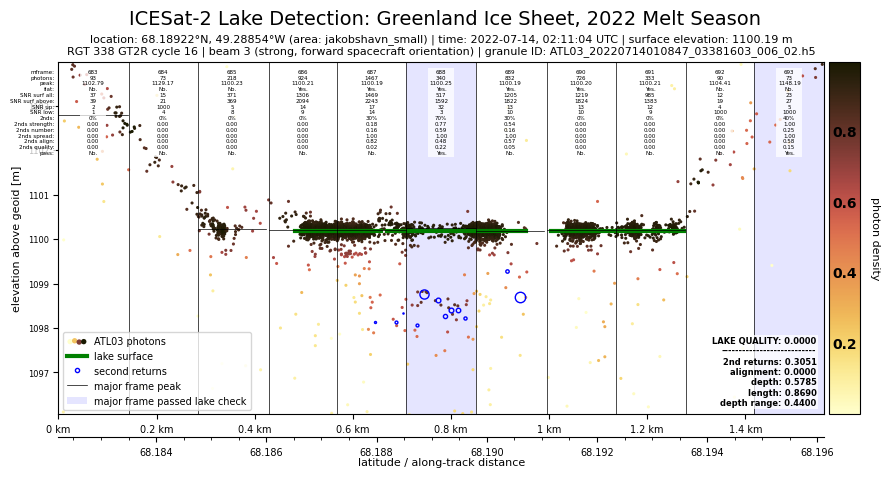

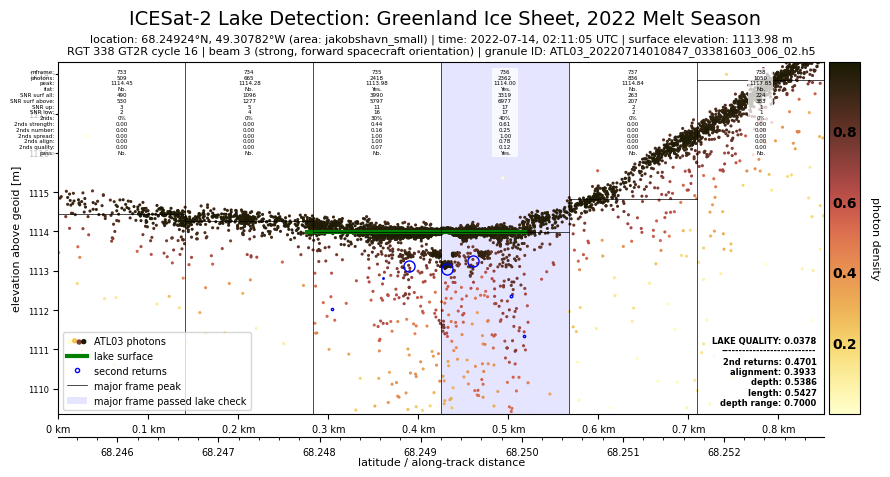

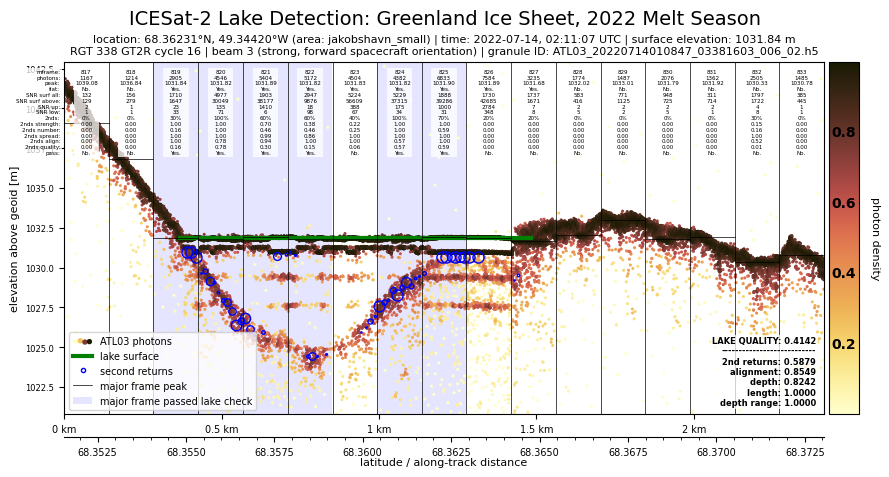

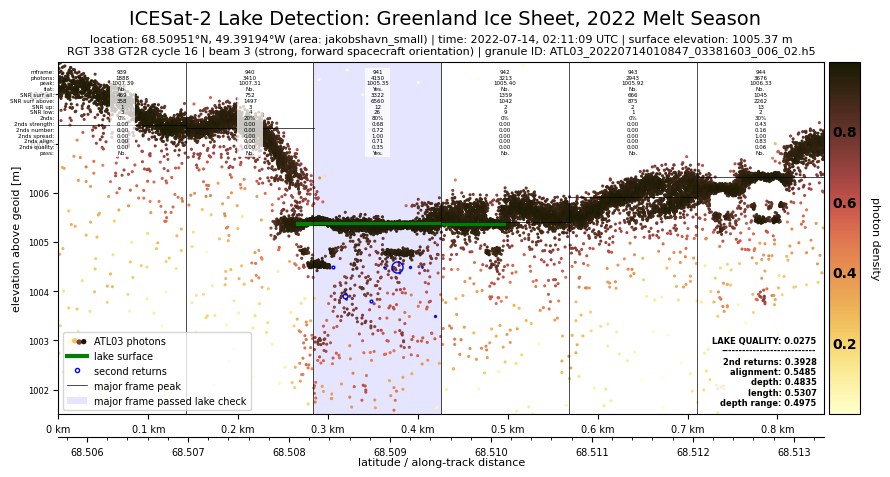

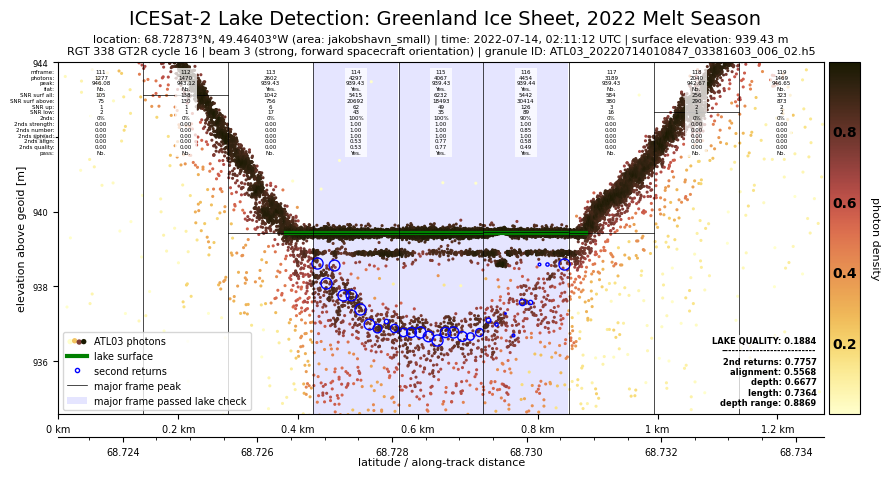

In [22]:
# detect melt lakes
lake_list = []
granule_stats = [0,0,0,0]

# for gtx in gtx_list:
for gtx in ['gt2r']:
    lakes_found, gtx_stats = detect_lakes(input_filename, gtx, args.polygon, verbose=False)
    for i in range(len(granule_stats)): granule_stats[i] += gtx_stats[i]
    lake_list += lakes_found

if granule_stats[0] > 0:
    with open('success.txt', 'w') as f: print('we got some data from NSIDC!!', file=f)
    print('Sucessfully retrieved data from NSIDC!!')
    
# print stats for granule
print('\nGRANULE STATS (length total, length lakes, photons total, photons lakes):%.3f,%.3f,%i,%i\n' % tuple(granule_stats))

# save plots and lake data dictionaries
for lake in lake_list:
    filename_base = 'lake_%05i_%s_%s_%s_%s_%s' % ((1.0-lake.detection_quality)*10000, lake.ice_sheet, lake.melt_season, 
                                                  lake.polygon_name, lake.granule_id[:-3], lake.gtx)
    # plot each lake and save to image
    fig = lake.plot_detected(min_width=0.0, min_depth=0.0)
    display(fig)

In [21]:
lake_list

In [1]:
from utils import *
from os import listdir, makedirs
from os.path import isfile, join, exists
import os
import rsa

# arguments for future script

In [2]:
granule = 'ATL03_20210715182907_03381203_005_01.h5'
shapefile = '/shapefiles/jakobshavn_small.shp'
gtxs = 'gt1l'

# download the specified granule via NSIDC
...and subset to the provided shapefile / only pull the variables needed

In [3]:
datadir = '/IS2data'

In [4]:
# %%capture celloutput 
download_granule_nsidc(granule, gtxs, shapefile, datadir, decedc(edc().u), decedc(edc().p))


  ATL03_20210715182907_03381203_005_01.h5, 5065.14 MB

Input shapefile: /shapefiles/jakobshavn_small.shp
Simplified polygon coordinates based on shapefile input: -49.59098555896507,69.10415896488335,-50.33805587146507,68.42374368072217,-50.01945235584007,68.20452489563448,-48.47038009021507,68.14325568125464,-48.16276290271507,68.66085965388693,-48.12980391834007,69.0963205694427,-49.59098555896507,69.10415896488335

API request URL:
https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL03&producer_granule_id=ATL03_20210715182907_03381203_005_01.h5&version=005&polygon=-49.59098555896507,69.10415896488335,-50.33805587146507,68.42374368072217,-50.01945235584007,68.20452489563448,-48.47038009021507,68.14325568125464,-48.16276290271507,68.66085965388693,-48.12980391834007,69.0963205694427,-49.59098555896507,69.10415896488335&Boundingshape={"type":"FeatureCollection","features":[{"id":"0","type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-49.59098555896507,6

# read in the .h5 subsetted granule file

In [5]:
filelist = [datadir[1:]+'/'+f for f in listdir(datadir[1:]) if isfile(join(datadir[1:], f)) & ('.h5' in f)]
print('\nNumber of processed ATL03 granules to read in: ' + str(len(filelist)))
    
photon_data, bckgrd_data, ancillary = read_atl03(filelist[0], geoid_h=True)
print_granule_stats(photon_data, bckgrd_data, ancillary, outfile='stats.txt')


Number of processed ATL03 granules to read in: 1
  reading in IS2data/processed_ATL03_20210715182907_03381203_005_01.h5
  reading in beam: gt1l  --> done.

*********************************
** GRANULE INFO AND STATISTICS **
*********************************

ATL03_20210715182907_03381203_005_01.h5
RGT: 338
cycle number: 12
spacecraft orientation: forward
beam configuation:
  gt1l : beam 6 (weak)
  gt1r : beam 5 (strong)
  gt2l : beam 4 (weak)
  gt2r : beam 3 (strong)
  gt3l : beam 2 (weak)
  gt3r : beam 1 (strong)

PHOTON DATA SUMMARY FOR BEAM GT1L
          count  nans           min           max
lat     2593192     0  6.817861e+01  6.904634e+01
lon     2593192     0 -4.965467e+01 -4.936601e+01
h       2593192     0 -2.645939e+02  1.594183e+03
dt      2593192     0  1.116091e+08  1.116091e+08
mframe  2593192     0  3.213661e+09  3.213661e+09
qual    2593192     0  0.000000e+00  2.000000e+00
xatc    2593192     0  7.603724e+06  7.701219e+06
geoid   2593192     0  2.883285e+01  3.21276